In [1]:
from pyspark.sql import SparkSession
from dms2dec.dms_convert import dms2dec
from shapely.geometry import Point, Polygon, LineString
from shapely import wkt
import pycountry
import subprocess
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType
import geopandas
import pandas as pd
import re
import os
import time

start_time = time.time()

# PEX file used to package third party packages and ship it to spark
# for more info visit https://databricks.com/blog/2020/12/22/how-to-manage-python-dependencies-in-pyspark.html
os.environ['PYSPARK_PYTHON'] = "./pyspark_pex_env.pex"

spark_session = SparkSession.builder \
        .master("spark://main:7077") \
        .appName("weak_scl_exp")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.shuffle.service.enabled", True)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores",2)\
        .config("spark.cores.max", 8)\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .config("spark.files", "pyspark_pex_env.pex").getOrCreate()


context = spark_session.sparkContext

The notebook is tested on measurements extracted from here https://www.ecad.eu/dailydata/predefinedseries.php
If you want to test it, make sure to remove the sources, elements, and stations files.

You might noticed that some regions don't have any colors. This could mean that there are no stations that reside in that region in the dataset.

In [2]:
MEASUREMENT = 'TG'
# needed countries
# Sweden, Germany, Greece, Finland
COUNTRIES_NEEDED = ['Sweden', 'Germany', 'Greece', 'Finland','Iceland', 'Italy', 'Norway', 'Spain', 'Poland','France']

In [3]:
PATH_TO_DATA = f"hdfs://main:9000/user/ubuntu/{MEASUREMENT}"
PATH_TO_STATIONS = "hdfs://main:9000/user/ubuntu/stations.txt"

# regex to get data in form of 111,222,aaaa,+aaa
# \+ is added to include the longitude and latitude
regex_header = re.compile(r"([A-Z\s]*,){4,}", re.IGNORECASE)
regex_data = re.compile(r"([\d\s\+\:-]*,){4,}", re.IGNORECASE)
regex_stations = re.compile(r"([\w\s\+\:-]*,){4,}", re.IGNORECASE)

# Process stations

In [4]:
stations_file = context.textFile(PATH_TO_STATIONS)

# get stations_data
stations_rows = stations_file.filter(lambda line: regex_stations.search(line) is not None)\
                 .map(lambda line: list(map(lambda x: x.strip(), line.split(","))))

# getting the data into a dataframe
stations_header = stations_rows.first()
df_stations = stations_rows.filter(lambda row: row != stations_header).toDF(stations_header)

In [5]:
# casting ID to int and taking needed stations
countries_alpha_2 = list(map(lambda country: pycountry.countries.get(name=country).alpha_2, COUNTRIES_NEEDED))

df_stations = df_stations.withColumn("STAID", df_stations['STAID'].cast('int'))
df_staitons_needed_countries = df_stations.filter(df_stations.CN.isin(countries_alpha_2))\
                               .drop("STANAME", "HGHT", "CN")

In [6]:
# convert from degree minutes seconds(DMS) to decimal
def DMS_TO_DEC(dms):
    return float(dms2dec(dms))

udf_DMS_TO_DEC = udf(DMS_TO_DEC, StringType())

df_stations_with_dms = df_staitons_needed_countries\
                                 .withColumn("LON", udf_DMS_TO_DEC("LON"))\
                                 .withColumn("LAT", udf_DMS_TO_DEC("LAT"))

In [7]:
# casting lon and lat to wkt for later usage 
def LON_LAT_TO_POINT(lon, lat):
    return geopandas.points_from_xy([lon], [lat])[0].to_wkt()

udf_TO_POINT = udf(LON_LAT_TO_POINT, StringType())

df_stations_points = df_stations_with_dms.withColumn("point", udf_TO_POINT("LON", "LAT")).drop("LAT", "LON")

In [8]:
# getting list of needed stations
needed_STAID = df_stations_points.select("STAID").toPandas()
needed_STAID_list = needed_STAID.STAID.values.tolist()

# Process data

In [9]:
# get all measurement files
one_copy_data_files = context.wholeTextFiles(PATH_TO_DATA)
two_copies_data_files = one_copy_data_files.union(one_copy_data_files)
three_copies_data_files = two_copies_data_files.union(one_copy_data_files)
four_copies_data_files = three_copies_data_files.union(one_copy_data_files)

#data_files = one_copy_data_files
#data_files = two_copies_data_files
#data_files = three_copies_data_files
data_files = four_copies_data_files

In [10]:
data_files.repartition(10)

MapPartitionsRDD[19] at coalesce at NativeMethodAccessorImpl.java:0

In [11]:
# get all files for needed stations
data_files_needed = data_files.filter(lambda file_pair: int(re.findall(r'\d+', file_pair[0])[1]) in needed_STAID_list)

In [12]:
# get the line containing the data
data_lines = data_files_needed.map(lambda x: x[1].split("\r\n"))\
             .map(lambda line: list(filter(regex_data.match,line)))

In [13]:
# get the index of the measurement
lines_of_single_file = data_files.first()[1].split("\r\n")
header_string = list(filter(regex_header.match, lines_of_single_file))[0]
data_header = list(map(lambda x: x.strip(), header_string.split(',')))
index_measurement = data_header.index(MEASUREMENT)

In [14]:
# get the average for each file with its corresponding station id
def get_mean_for_file(lines):
    lines_splited = list(map(lambda x: x.split(','), lines))

    measurement_values = list(map(lambda x: int(x[index_measurement]),lines_splited))
    measurement_values_valid = list(filter(lambda x: x != -9999, measurement_values))
    mean = sum(measurement_values_valid) / len(lines_splited)
    if MEASUREMENT == "TG":
        mean *= 0.1
    
    return (int(lines_splited[0][0]), mean)

data_formated = data_lines.map(get_mean_for_file)

In [15]:
# only the id of the station and the the measurement is needed
data_header_used = ["STAID_", "AVG"]

In [16]:
df_data = data_formated.toDF(data_header_used)

In [17]:
df_data_by_station = df_data.select('AVG',\
                             'STAID_')\
                     .groupBy("STAID_")\
                     .agg({'AVG': 'mean'})\
                     .withColumnRenamed("avg(AVG)", "AVG")

In [18]:
# include the mean measurement in each station
df_stations_data = df_stations_points.join(df_data, df_stations_points.STAID == df_data.STAID_, 'inner').drop("STAID_", "STAID")

In [19]:
# download shape files from https://www.diva-gis.org/gData and store them in shape_files
PATH_TO_SHAPE_FILES = "./shape_files"
countries_alpha_3 = map(lambda country: pycountry.countries.get(name=country).alpha_3, COUNTRIES_NEEDED)
countries_alpha_3_need_download = list(filter(lambda country: not os.path.exists(f"{PATH_TO_SHAPE_FILES}/{country}"), countries_alpha_3))

for alpha_3 in countries_alpha_3_need_download:
    subprocess.run(f'wget http://biogeo.ucdavis.edu/data/diva/adm/{alpha_3}_adm.zip &&'
                   f' mkdir -p {PATH_TO_SHAPE_FILES}/{alpha_3} &&'
                   f' unzip {alpha_3}_adm.zip -d {PATH_TO_SHAPE_FILES}/{alpha_3} &&'
                   f' rm {alpha_3}_adm.zip'
                   , shell=True)

In [20]:
# include all the shape files in one dataframe
geo_df = pd.DataFrame()
for country in COUNTRIES_NEEDED:
    alpha_3 = pycountry.countries.get(name=country).alpha_3
    geo_df = geo_df.append(geopandas.read_file(f"{PATH_TO_SHAPE_FILES}/{alpha_3}/{alpha_3}_adm1.shp"))

In [21]:
# get the data from spark to be processed
pandas_df_stations = df_stations_data.toPandas()

In [22]:
# get the region for each station
gdf_data = geopandas.GeoDataFrame(pandas_df_stations['AVG'], geometry=list(map(lambda x: wkt.loads(x), pandas_df_stations['point'])), crs="EPSG:4326")
geo_df_index_ID_1 = geo_df.set_index("ID_1")
gdf_data['ID_1'] = -1
for index1, gdf in gdf_data.iterrows():
    for index2, geo in geo_df.iterrows():
        if geo['geometry'].contains(gdf.geometry):
            gdf_data.at[index1, 'ID_1'] = geo['ID_1']
            break

In [23]:
geo_df_joined = gdf_data.drop(['geometry'], axis=1).merge(geo_df, on="ID_1", how='outer')
index_names = geo_df_joined[ (geo_df_joined['ID_1'] == -1)].index 

geo_df_joined.drop(index_names, inplace = True) 

In [24]:
geo_df_index_ID_1 = geo_df.set_index("ID_1")

In [25]:
geo_df_index_ID_1["AVG"] = geo_df_joined.groupby(by=['ID_1']).mean().AVG

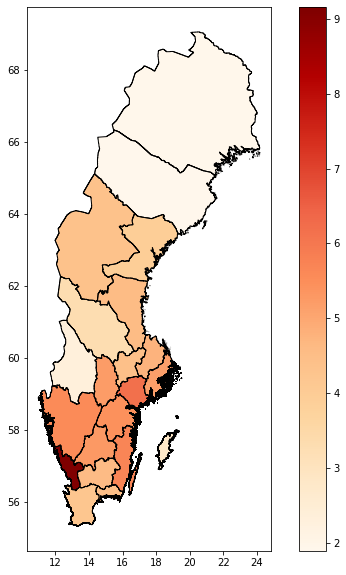

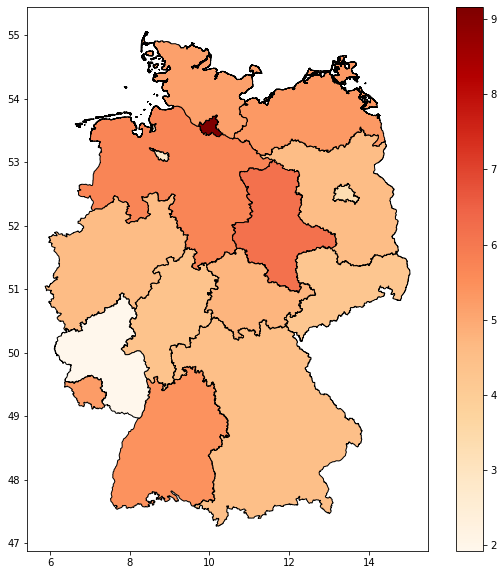

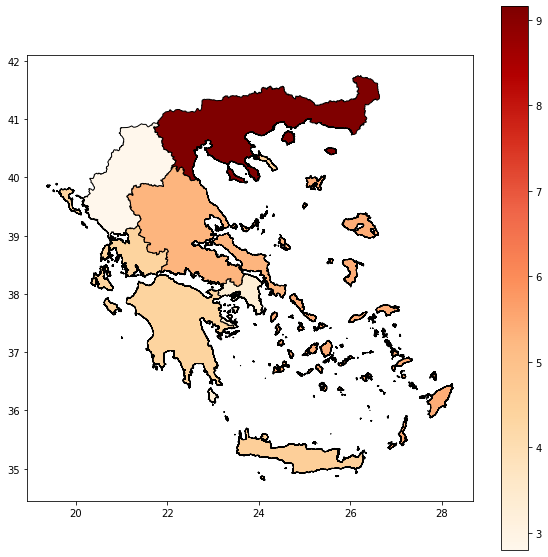

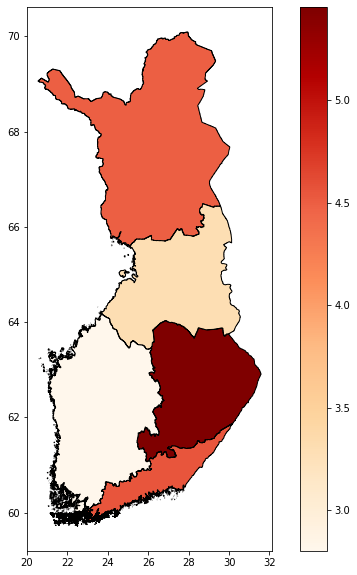

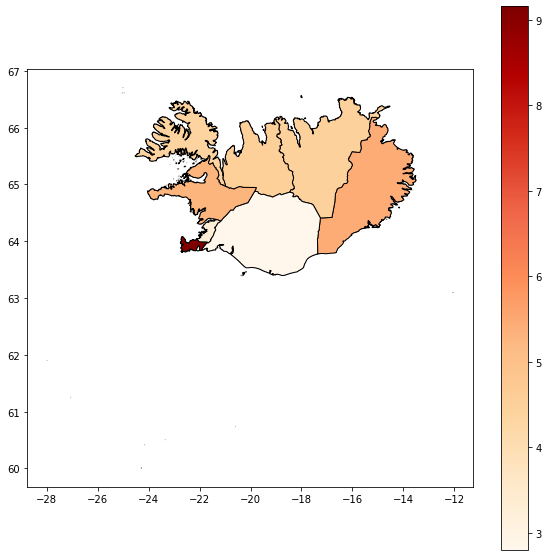

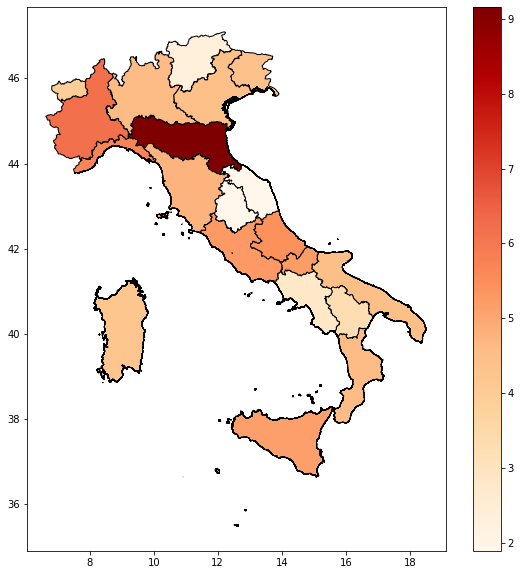

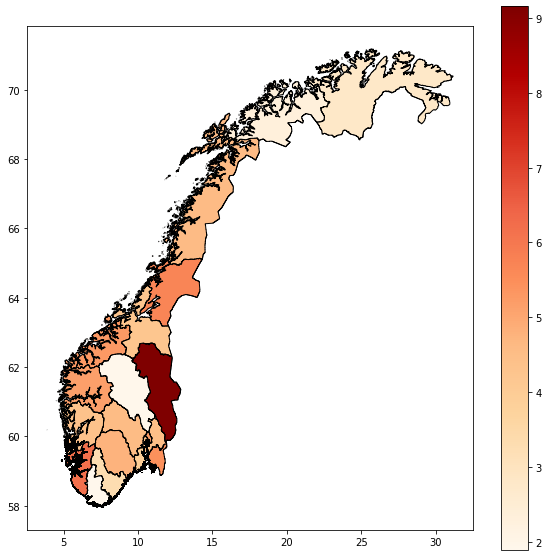

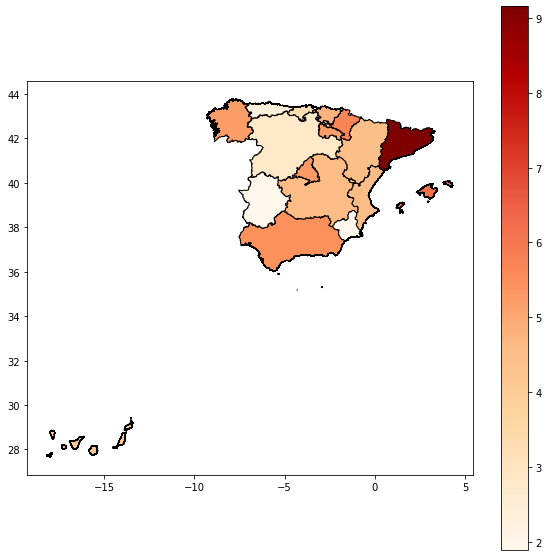

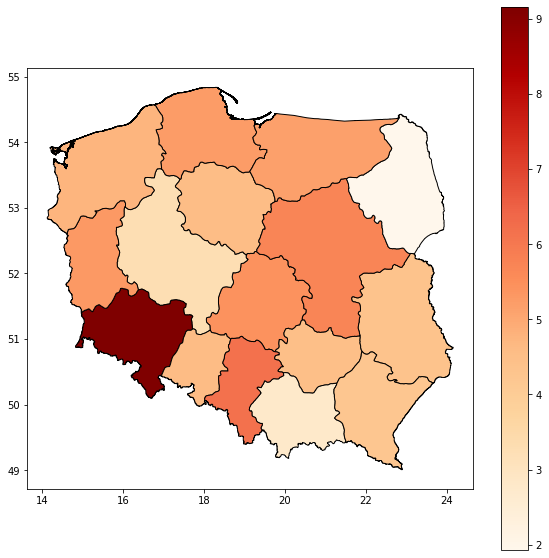

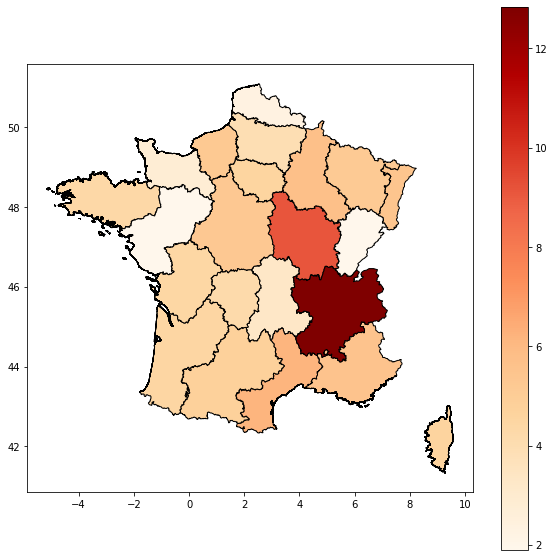

In [26]:
for country in COUNTRIES_NEEDED:    
    geo_df_index_ID_1[geo_df_index_ID_1.NAME_0 == country].plot(column='AVG', cmap='OrRd', edgecolor='k', legend=True, figsize=(10,10))

In [27]:
context.stop()

In [28]:
end_time = time.time()
print(f"It took {end_time - start_time} to finish the app")

It took 954.5744128227234 to finish the app
